<a href="https://colab.research.google.com/github/SongheeJo/aiffelthon/blob/main/jungin/Baseline_ver2_all_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


필요한 라이브러리 다운로드

In [ ]:
!pip install tensorflow-io[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 1.3 MB/s 
     |████████████████████████████████| 511.7 MB 7.1 kB/s 
     |████████████████████████████████| 1.6 MB 58.0 MB/s 
     |████████████████████████████████| 438 kB 47.3 MB/s 
     |████████████████████████████████| 5.8 MB 52.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [ ]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 11.7 MB/s 


In [ ]:
!pip install cmapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for cmapy: filename=cmapy-0.6.6-py3-none-any.whl size=3959 sha256=bb99b0da33ac37dae3ca2cfa4d354987a8a2bbb14b870be0b49ab81b856f4b4a
  Stored in directory: /root/.cache/pip/wheels/49/9a/c8/486d47fd07a9ca1b91602dd040f727313dbeaa059a45d77521
Successfully built cmapy


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import soundfile as sf
import librosa as lb
import cv2
import cmapy
import os


In [ ]:
#butterworth
from scipy.signal import butter, sosfilt, sosfreqz

#frequency masking
import tensorflow_io as tfio

#shift
import nlpaug.augmenter.audio as naa

In [ ]:
root = '/content/drive/MyDrive/aiffel/aiffelthon/'
AUTOTUNE = tf.data.experimental.AUTOTUNE
sr = 16000

wav 파일을 start end에 맞게 잘라줍니다

crackle wheezing에 대한 컬럼을 추가합니다

concatnate augmentation을 통해 data imbalance를 해결합니다

df = raw data + concatenate augmented data

In [ ]:
processed = pd.read_csv(root + 'processed.csv') # raw = 6898
df = pd.read_csv(root + 'aug_added_df.csv') # raw + concat = 13032

In [ ]:
df

,Unnamed: 0,Unnamed: 0.1,start,end,pid,mode,filename,disease,crack_wheeze
0,0,0.0,1.862,5.718,160.0,mc,160_1b3_Al_mc_AKGC417L_0.wav,COPD,2
1,1,1.0,5.718,9.725,160.0,mc,160_1b3_Al_mc_AKGC417L_1.wav,COPD,3
2,2,2.0,9.725,13.614,160.0,mc,160_1b3_Al_mc_AKGC417L_2.wav,COPD,2
3,3,3.0,13.614,17.671,160.0,mc,160_1b3_Al_mc_AKGC417L_3.wav,COPD,2
4,4,4.0,17.671,19.541,160.0,mc,160_1b3_Al_mc_AKGC417L_4.wav,COPD,0
...,...,...,...,...,...,...,...,...,...
13027,13027,NaN,NaN,NaN,NaN,NaN,aug_both_503.wav,NaN,3
13028,13028,NaN,NaN,NaN,NaN,NaN,aug_both_504.wav,NaN,3
13029,13029,NaN,NaN,NaN,NaN,NaN,aug_both_505.wav,NaN,3
13030,13030,NaN,NaN,NaN,NaN,NaN,aug_both_506.wav,NaN,3


모든 데이터에 duplicate padding을 적용하고 wav로 저장합니다.

df는 그대로 사용할 수 있습니다.

In [ ]:
def check_length(audio, list_df, maxLen, save_path):
    if len(audio)/16000 > maxLen:
      audio = audio_slicing(audio)
      sf.write(file = save_path, data = audio, samplerate= sr)
      list_df.append(audio)
    else:
        new = np.concatenate((audio, audio))
        return check_length(new, list_df, maxLen, save_path)

In [ ]:
def audio_slicing(signal, max = 7 * sr):
  if len(signal) > max:
    return signal[:max]
  else:
    return signal

In [ ]:
df_pad = []
maxLen = 7

In [ ]:
'''#duplicated padding_train
for index, row in df.iterrows():

  filename = row['filename']  
  audio_file = root + 'raw_concat_no_pad/'+ filename
  audio_data, _ = lb.load(audio_file, sr=16000)
  duplicated = np.concatenate((audio_data, audio_data))
  check_data = len(duplicated) / 16000
  save_path = root + 'raw_concat_pad_7sec_2/' + filename

  if check_data > maxLen:
    duplicated = audio_slicing(duplicated)
    sf.write(file = save_path, data = duplicated, samplerate= sr)
    df_pad.append(duplicated)
    
  else:
    check_length(duplicated, df_pad, maxLen=maxLen, save_path=save_path)
  
  if index % 100 == 0:
    print(index)'''

"#duplicated padding_train\nfor index, row in df.iterrows():\n\n  filename = row['filename']  \n  audio_file = root + 'raw_concat_no_pad/'+ filename\n  audio_data, _ = lb.load(audio_file, sr=16000)\n  duplicated = np.concatenate((audio_data, audio_data))\n  check_data = len(duplicated) / 16000\n  save_path = root + 'raw_concat_pad_7sec_2/' + filename\n\n  if check_data > maxLen:\n    duplicated = audio_slicing(duplicated)\n    sf.write(file = save_path, data = duplicated, samplerate= sr)\n    df_pad.append(duplicated)\n    \n  else:\n    check_length(duplicated, df_pad, maxLen=maxLen, save_path=save_path)\n  \n  if index % 100 == 0:\n    print(index)"

raw data에서만 test data를 뽑기 위해 processed에서 train test split을 해주고

전체 df에서 test data를 뺀 것을 train data로 사용합니다.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(processed,
                                                    processed.crack_wheeze,
                                                    stratify=processed['crack_wheeze'],
                                                    random_state=42,
                                                    test_size=0.4)

In [ ]:
test_df = x_test

In [ ]:
train_df = df.drop(x_test.index)
y_train = train_df.crack_wheeze

In [ ]:
len(train_df), len(y_train)

(10272, 10272)

In [ ]:
len(test_df), len(y_test)

(2760, 2760)

wav 파일에 대해 shift, speed augmentation을 적용합니다

In [ ]:
import nlpaug.augmenter.audio as naa
from random import uniform

def audio_shift(signal):
  luck = np.random.randint(0,2) # 50% 확률 만들기
  if luck == 0:
    aug = naa.ShiftAug(sampling_rate=sr, duration=uniform(1.5,3.5)) #0과 1 사이의 실수
    return aug.augment(signal)
  else:
    return signal

In [ ]:
def audio_speed(signal):
  luck = np.random.randint(0,2)
  if luck == 0:
    aug = naa.SpeedAug(zone=(0.2, 0.8), coverage=0.5, factor=(0.5, 1), stateless=True) #0과 1 사이의 실수
    return aug.augment(signal)
  else:
    return signal 

In [ ]:
def audio_slicing(signal, max = 7 * sr):
  if len(signal) > max:
    return signal[:max]
  else:
    return signal

In [ ]:
def pre_aug(signal,sr=sr):
  audio = audio_shift(signal)
  audio = audio_speed(audio)
  audio = audio_slicing(audio)
  return audio

wav 파일을 이미지화하는(Mel-spectrogram)함수입니다

In [ ]:
n_mels=128
f_min=100
f_max=16000
nfft=2048
hop= nfft//4

In [ ]:
def create_mel_raw(signal, sr=16000, n_mels=128, f_min=100, f_max=16000, nfft=2048, hop=512, resz=1):
    S = lb.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, fmin=f_min, fmax=f_max, n_fft=nfft, hop_length=nfft//4)
    S = lb.power_to_db(S, ref=np.max) # 다음엔 median으로
    S = (S - np.min(S)) / (np.max(S) - np.min(S)) 
    S *= 255
    img = cv2.applyColorMap(S.astype(np.uint8), cmapy.cmap('magma'))
    height, width, _ = img.shape
    if resz > 0:
        img = cv2.resize(img, (width*resz, height*resz), interpolation=cv2.INTER_LINEAR) #bicubic interpolation
    img = cv2.flip(img, 0)
    return img

masking augmentation 함수입니다

In [ ]:
def time_mask(mel, param = 30):
  return tfio.audio.time_mask(mel, param = param)

def freq_mask(mel):
  return tfio.audio.freq_mask(mel, param = 30)

def process_mask(mel):
  prob = np.random.randint(0,3)
  if prob == 0:
    return time_mask(mel)
  elif prob == 1:
    return freq_mask(mel)
  else:
    return time_mask(mel, param = 1)

구현한 preprocess와 augmentation 함수를 하나의 for문에 넣고 돌립니다.

In [ ]:
train_list = [] # duplicate 패딩 된 데이터
c = 0
for idx, row in train_df.iterrows():
  #데이터 load
  sample_wav, _ = lb.load(root + 'raw_concat_pad_7sec_2/' + row.filename, sr = sr)
  
  #shift, speed augmentation
  aug = pre_aug(sample_wav) 

  #creat Mel-spectrogram and apply blank region clipping
  audio_image = cv2.cvtColor(create_mel_raw(aug), cv2.COLOR_BGR2RGB)

  audio_raw_gray = cv2.cvtColor(create_mel_raw(aug), cv2.COLOR_BGR2GRAY)
  audio_raw_gray[audio_raw_gray < 10] = 0
  for row in range(audio_raw_gray.shape[0]):
    black_percent = len(np.where(audio_raw_gray[row,:]==np.min(audio_raw_gray))[0])/len(audio_raw_gray[row,:])
    if black_percent < 0.80:
      break

  if (row+1)*3 < audio_image.shape[0]:
    audio_image = audio_image[(row+1)*3:, :, :]

  audio_image = cv2.resize(audio_image, (audio_image.shape[1], n_mels*3), interpolation=cv2.INTER_LINEAR)
  audio_image, _, __ = cv2.split(audio_image)
  audio_image = cv2.resize(audio_image, (219,128), interpolation=cv2.INTER_LINEAR)
  audio_image = np.array(audio_image, dtype=float)
  audio_image = (audio_image - np.min(audio_image)) / (np.max(audio_image) - np.min(audio_image))

  #masking augmentation
  mask = process_mask(audio_image)
  
  train_list.append(mask)
  c += 1

  if c % 100 == 0:
    print(c)

넘파이 배열로 저장합니다

In [ ]:
x_train_1 = np.array(train_list)
np.save(root + 'ref_max_13032.npy', x_train_1)

In [ ]:
x_train_1 = np.load(root + 'ref_max_13032.npy')

augmentation 잘 적용됐는지 확인

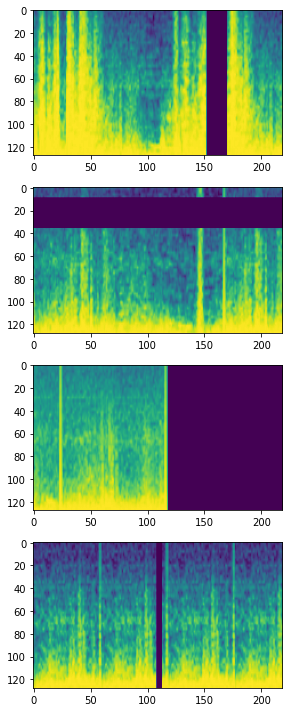

In [ ]:
plt.figure(figsize = (10,10))

for idx in range(4):
  plt.subplot(4,1,idx+1)
  plt.tight_layout()
  plt.imshow(x_train_1[idx])

테스트 데이터에 Mel-spectrogram과 blank region clipping을  적용합니다(augmentation을 제외)

In [ ]:
test_list = [] # duplicate 패딩 된 데이터
c = 0
for idx, row in test_df.iterrows():
  sample_wav, _ = lb.load(root + 'raw_concat_pad_7sec_2/' + row.filename, sr = sr)

  audio_image = cv2.cvtColor(create_mel_raw(sample_wav), cv2.COLOR_BGR2RGB)

  audio_raw_gray = cv2.cvtColor(create_mel_raw(sample_wav), cv2.COLOR_BGR2GRAY)
  audio_raw_gray[audio_raw_gray < 10] = 0
  for row in range(audio_raw_gray.shape[0]):
    black_percent = len(np.where(audio_raw_gray[row,:]==np.min(audio_raw_gray))[0])/len(audio_raw_gray[row,:])
    if black_percent < 0.80:
      break

  if (row+1)*3 < audio_image.shape[0]:
    audio_image = audio_image[(row+1)*3:, :, :]

  audio_image = cv2.resize(audio_image, (audio_image.shape[1], n_mels*3), interpolation=cv2.INTER_LINEAR)
  audio_image, _, __ = cv2.split(audio_image)
  audio_image = cv2.resize(audio_image, (219,128), interpolation=cv2.INTER_LINEAR)
  audio_image = np.array(audio_image, dtype=float)
  audio_image = (audio_image - np.min(audio_image)) / (np.max(audio_image) - np.min(audio_image))
  
  test_list.append(audio_image)
  c += 1

  if c % 100 == 0:
    print(c)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700


In [ ]:
len(train_list)

10272

In [ ]:
x_test_1 = np.array(test_list)
np.save(root + 'ref_max_13032_test.npy', x_test_1)

In [ ]:
x_test_1 = np.load(root + 'ref_max_13032_test.npy')

In [ ]:
y_train_1 = np.array(y_train)
y_test_1 = np.array(y_test)

In [ ]:
# ResNet34 block
def build_resnet_block_34(input_layer, num_cnn, channel, block_num, unit_one=False):

  x = input_layer
  

  for cnn_num in range(num_cnn):

            skip = x

            if not unit_one and cnn_num == 0: #첫번쨰 유닛이 아니고 첫번째 레이어일 때 stride=2 추가
              
              x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                strides = 2,
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_first_conv{cnn_num}'
                )(x)

            else:
              x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
                )(x)

            
            x = keras.layers.BatchNormalization(
                name=f'block{block_num}_1_bn_{cnn_num}')(x)


            x = keras.layers.Activation(
                'relu', name = f'block{block_num}_activtion_{cnn_num}')(x)
            
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_2_conv{cnn_num}'
            )(x)

            if not unit_one: #첫번째 유닛이 아니고 첫번째 레이어일 때 skip레이어 추가
              if cnn_num == 0:

                skip = keras.layers.Conv2D(
                 filters=channel,
                 kernel_size=(1,1),
                 strides = 2,
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='same',
                 name=f'block{block_num}_skip_conv{cnn_num}'
                 )(skip)


            x = keras.layers.BatchNormalization(
                name=f'block{block_num}_2_bn_{cnn_num}')(x)


            if not unit_one: #첫번째 유닛이 아니고 첫번째 레이어일 때 batchnorm 추가
              if cnn_num == 0:
                skip = keras.layers.BatchNormalization(
                  name=f'block{block_num}_skip_bn_{cnn_num}')(skip)


            x = keras.layers.Add()([x,skip])

            x = keras.layers.Activation(
                'relu', name = f'block{block_num}_1_activtion_{cnn_num}')(x)

  return x



In [ ]:
def resnet_34(input_shape=(128,219,1),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=4):

  input_layer = keras.layers.Input(shape=input_shape) #input layer 만들기
  output = input_layer

  output = keras.layers.Conv2D(
                 filters=64,
                 kernel_size=(7,7),
                 strides = 2,
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='same',
                 name='block_0_conv'
              )(output)

  output = keras.layers.BatchNormalization(
                name='block_0_bn')(output)

  output = keras.layers.Activation(
                'relu', name = 'block_0_activtion')(output)

  output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2, name = 'MaxPooling')(output)
    

  for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)): #첫번째 유닛일 때 unit_one = True
    if i == 0:
      output = build_resnet_block_34(output, num_cnn=num_cnn, channel=channel, block_num=i, unit_one = True)
    else:
      output = build_resnet_block_34(output, num_cnn=num_cnn, channel=channel, block_num=i)


  output = keras.layers.AveragePooling2D(pool_size = (1,1),
                                      name = 'last_AveragePooling')(output)

  output = keras.layers.Flatten(name = 'Flatten')(output)
  
  output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

  model = keras.Model(inputs=input_layer, outputs=output)

  return model

In [ ]:
resnet_34 = resnet_34()
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 219, 1  0           []                               
                                )]                                                                
                                                                                                  
 block_0_conv (Conv2D)          (None, 64, 110, 64)  3200        ['input_1[0][0]']                
                                                                                                  
 block_0_bn (BatchNormalization  (None, 64, 110, 64)  256        ['block_0_conv[0][0]']           
 )                                                                                                
                                                                                              

In [ ]:
accuracy='sparse_categorical_accuracy'
sparseLoss=keras.losses.SparseCategoricalCrossentropy()

from keras import backend as K
K.clear_session()
resnet_34.compile(optimizer='nadam', loss=sparseLoss, metrics=[accuracy])
K.set_value(resnet_34.optimizer.learning_rate, 0.001)

In [ ]:
file_name = '/content/drive/MyDrive/aiffel/aiffelthon/model/resnet-001.h5'
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-12,mode='min'), #미분하다 막히면 lr 변경해줌
    tf.keras.callbacks.ModelCheckpoint(file_name, monitor='val_loss', verbose=0, save_best_only=True,)
]

In [ ]:
history=resnet_34.fit(
    x_train_1,
    y_train_1,
    batch_size = 64,
    validation_data=(x_test_1,y_test_1),
    epochs=100,
    verbose=1,
    callbacks=my_callbacks
)

Epoch 1/100
161/161 [==============================] - 38s 163ms/step - loss: 5.5308 - sparse_categorical_accuracy: 0.2703 - val_loss: 1.3866 - val_sparse_categorical_accuracy: 0.0732 - lr: 0.0010
Epoch 2/100
161/161 [==============================] - 21s 131ms/step - loss: 3.9139 - sparse_categorical_accuracy: 0.2842 - val_loss: 1.3892 - val_sparse_categorical_accuracy: 0.1649 - lr: 0.0010
Epoch 3/100
161/161 [==============================] - 22s 138ms/step - loss: 3.1522 - sparse_categorical_accuracy: 0.3050 - val_loss: 1.9560 - val_sparse_categorical_accuracy: 0.1275 - lr: 0.0010
Epoch 4/100
161/161 [==============================] - 22s 139ms/step - loss: 3.0033 - sparse_categorical_accuracy: 0.2979 - val_loss: 17.8123 - val_sparse_categorical_accuracy: 0.4837 - lr: 0.0010
Epoch 5/100
161/161 [==============================] - 22s 138ms/step - loss: 1.7020 - sparse_categorical_accuracy: 0.3508 - val_loss: 1.4698 - val_sparse_categorical_accuracy: 0.2620 - lr: 1.0000e-04
Epoch 6/10

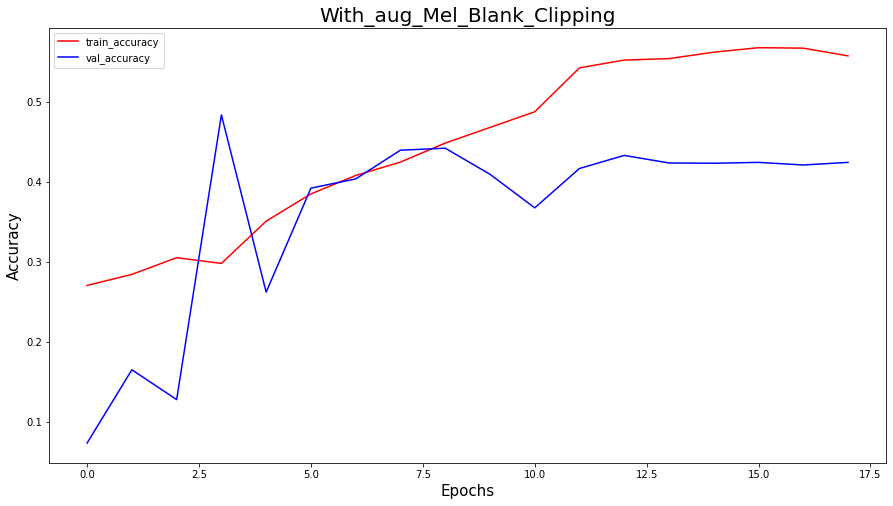

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(history.history['sparse_categorical_accuracy'], label = 'train_accuracy', linestyle='solid', color='r')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy', linestyle='solid', color='b')

plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.title('With_aug_Mel_Blank_Clipping', fontsize = 20)
plt.show()

classification report

In [ ]:
y_pred = resnet_34.predict(x_test_1)

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(np.argmax(y_pred, axis = 1), y_test_1)

array([[795, 292, 136,  78],
       [290, 259,  84,  54],
       [200,  71,  76,  29],
       [172, 124,  59,  41]])

In [ ]:
from sklearn.metrics import classification_report

target_names=['Normal', 'Crackle', 'Wheeze', 'Both']

clf_report = classification_report(y_test_1, np.argmax(y_pred, axis = 1), target_names=target_names, output_dict=True)
print(classification_report(y_test_1, np.argmax(y_pred, axis = 1), target_names=target_names))


              precision    recall  f1-score   support

      Normal       0.61      0.55      0.58      1457
     Crackle       0.38      0.35      0.36       746
      Wheeze       0.20      0.21      0.21       355
        Both       0.10      0.20      0.14       202

    accuracy                           0.42      2760
   macro avg       0.32      0.33      0.32      2760
weighted avg       0.46      0.42      0.44      2760



trial_2(resnet 보다 더 간단한 모델인데 더 성능 잘 나옴)

In [ ]:
#주석 부분은 skip layer 시도했다가 잘 안돼서 주석처리한 것입니다.

mSpec_input=keras.layers.Input(shape=(128,219,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

skip_x = x
skip_x = keras.layers.Conv2D(96,3,strides=(2,4),padding='same')(skip_x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x = keras.layers.Add()([x,skip_x])
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.GlobalMaxPooling2D()(x)

x=keras.layers.Dropout(0.2)(x)
x=keras.layers.Dense(50,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(25,activation='relu')(x)
x=keras.layers.Dropout(0.3)(x)
output=keras.layers.Dense(4,activation='softmax')(x)


mSpec_model=keras.Model(mSpec_input, output, name="mSpecModel")

In [ ]:
mSpec_model.summary()

Model: "mSpecModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mSpecInput (InputLayer)        [(None, 128, 219, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 73, 32)   832         ['mSpecInput[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 73, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                         

In [ ]:
accuracy='sparse_categorical_accuracy'
sparseLoss=keras.losses.SparseCategoricalCrossentropy()

from keras import backend as K
K.clear_session()
mSpec_model.compile(optimizer='nadam', loss=sparseLoss, metrics=[accuracy])
K.set_value(mSpec_model.optimizer.learning_rate, 0.001)

In [ ]:
file_name = '/content/drive/MyDrive/aiffel/aiffelthon/model/mSpec_model-001.h5'
my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=1e-12,mode='min'), #미분하다 막히면 lr 변경해줌
    tf.keras.callbacks.ModelCheckpoint(file_name, monitor='val_loss', verbose=0, save_best_only=True,)
]

In [ ]:
history_2 = mSpec_model.fit(
    x_train_1,
    y_train_1,
    batch_size = 16,
    validation_data=(x_test_1,y_test_1),
    epochs=200,
    verbose=1,
    callbacks=my_callbacks
)

Epoch 1/200
642/642 [==============================] - 9s 11ms/step - loss: 1.4168 - sparse_categorical_accuracy: 0.2705 - val_loss: 1.4161 - val_sparse_categorical_accuracy: 0.0732 - lr: 0.0010
Epoch 2/200
642/642 [==============================] - 6s 10ms/step - loss: 1.3773 - sparse_categorical_accuracy: 0.2940 - val_loss: 1.4092 - val_sparse_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 3/200
642/642 [==============================] - 6s 9ms/step - loss: 1.3503 - sparse_categorical_accuracy: 0.3221 - val_loss: 1.2663 - val_sparse_categorical_accuracy: 0.5286 - lr: 0.0010
Epoch 4/200
642/642 [==============================] - 6s 10ms/step - loss: 1.3290 - sparse_categorical_accuracy: 0.3386 - val_loss: 1.1952 - val_sparse_categorical_accuracy: 0.5243 - lr: 0.0010
Epoch 5/200
642/642 [==============================] - 7s 11ms/step - loss: 1.3118 - sparse_categorical_accuracy: 0.3502 - val_loss: 1.2665 - val_sparse_categorical_accuracy: 0.4909 - lr: 0.0010
Epoch 6/200
642/642 [=====

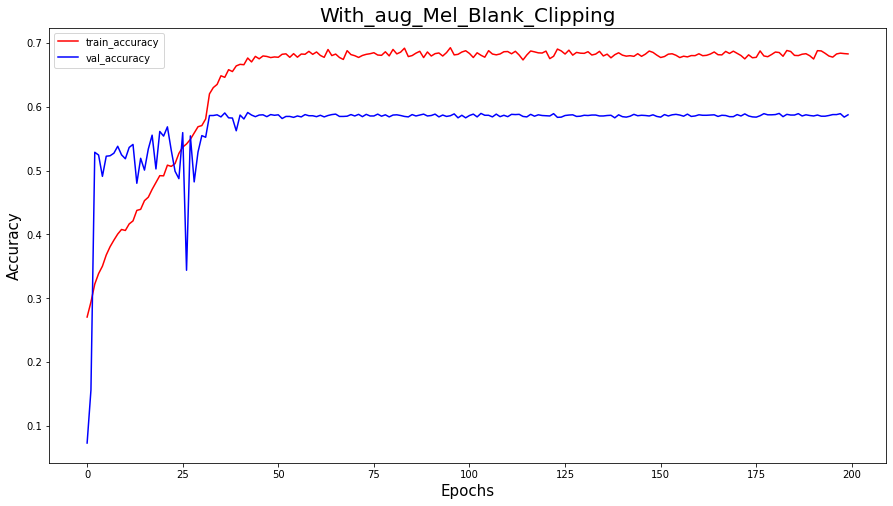

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(history_2.history['sparse_categorical_accuracy'], label = 'train_accuracy', linestyle='solid', color='r')
plt.plot(history_2.history['val_sparse_categorical_accuracy'], label = 'val_accuracy', linestyle='solid', color='b')

plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.title('With_aug_Mel_Blank_Clipping', fontsize = 20)
plt.show()

In [ ]:
y_pred = mSpec_model.predict(x_test_1)

In [ ]:
clf_report = classification_report(y_test_1, np.argmax(y_pred, axis = 1), target_names=target_names, output_dict=True)
print(classification_report(y_test_1, np.argmax(y_pred, axis = 1), target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.68      0.73      0.71      1457
     Crackle       0.47      0.48      0.47       746
      Wheeze       0.52      0.38      0.44       355
        Both       0.36      0.32      0.34       202

    accuracy                           0.59      2760
   macro avg       0.51      0.48      0.49      2760
weighted avg       0.58      0.59      0.58      2760



In [ ]:
with open( root+ "clf_report_resnet34_1.txt", "w") as text_file:
    print(classification_report(y_test_1, np.argmax(y_pred, axis = 1), target_names=target_names), file=text_file)
